# **CK+**

In [50]:
import pylab as pl
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
import matplotlib.image as mplib 
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC
import joblib
from skimage.feature import hog
from skimage import exposure

In [51]:
data_path = 'F:\ckextended\CK+48'
data_dir_list = os.listdir(data_path)

img_data_list = []
img_data = []
num_images = []

for dataset in ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']:
    img_list = os.listdir(data_path + '/' + dataset)
    print('Loaded the images of dataset-' + '{}\n'.format(dataset))
    num_images.append(len(img_list))
    for img in img_list:
        input_img = cv2.imread(data_path + '/' + dataset + '/' + img, 0)  # Read image in grayscale
        img_data_list.append(input_img)

img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data / 255

n_samples, h, w = img_data.shape
np.random.seed(42)

img_data = img_data.reshape(n_samples, -1)

img_data.shape

Loaded the images of dataset-anger

Loaded the images of dataset-contempt

Loaded the images of dataset-disgust

Loaded the images of dataset-fear

Loaded the images of dataset-happy



Loaded the images of dataset-sadness

Loaded the images of dataset-surprise



(945, 2304)

In [52]:

num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,), dtype='int64')

labels[0:45] = 0  # 45
labels[45:63] = 1  # 18
labels[63:122] = 2  # 59
labels[122:147] = 3  # 25
labels[147:216] = 4  # 69
labels[216:244] = 5  # 28
labels[244:327] = 6  # 83

names = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

n_classes = len(names)

def getLabel(id):
    return ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'][id]

In [53]:
Y = to_categorical(labels, num_classes)
y = labels
X_train, X_test, y_train, y_test = train_test_split(img_data, y, test_size=0.20, shuffle=True, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((756, 2304), (756,), (189, 2304), (189,))

In [54]:
# Extract HOG features
def extract_hog_features(images):
    hog_features = []
    for img in images:
        fd, hog_image = hog(img.reshape((h, w)), orientations=8, pixels_per_cell=(4, 4),
                            cells_per_block=(1, 1), visualize=True)
        hog_features.append(fd)
    return np.array(hog_features)

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)


In [ ]:
# PCA
n_components = 120
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_hog)
X_train_pca = pca.transform(X_train_hog)
X_test_pca = pca.transform(X_test_hog)

joblib.dump(pca, 'pca.joblib')

['pca.joblib']

In [ ]:
# SVM
print("Fitting the classifier to the training set")
param_grid = {
    'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6],
    'gamma': [1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2],
}

clf = GridSearchCV(SVC(kernel='sigmoid', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)

print("Best estimator found by grid search:")
best_estimator = clf.best_estimator_
print(clf.best_estimator_)
joblib.dump(clf, 'svm_model.joblib')

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=5000.0, class_weight='balanced', gamma=5e-05, kernel='sigmoid')


['svm_model.joblib']

In [ ]:
print("Predicting the people names on the testing set")
y_pred = best_estimator.predict(X_test_pca)

Predicting the people names on the testing set


In [ ]:
print(classification_report(y_test, y_pred, target_names=names))

              precision    recall  f1-score   support

       anger       1.00      1.00      1.00         6
    contempt       0.97      1.00      0.98       126
     disgust       1.00      0.93      0.97        15
        fear       0.80      1.00      0.89         4
       happy       1.00      0.83      0.91        12
     sadness       1.00      1.00      1.00         2
    surprise       1.00      0.92      0.96        24

    accuracy                           0.97       189
   macro avg       0.97      0.95      0.96       189
weighted avg       0.98      0.97      0.97       189



In [ ]:
print(confusion_matrix(y_test, y_pred, labels=range(num_classes)))

[[  6   0   0   0   0   0   0]
 [  0 126   0   0   0   0   0]
 [  0   0  14   1   0   0   0]
 [  0   0   0   4   0   0   0]
 [  0   2   0   0  10   0   0]
 [  0   0   0   0   0   2   0]
 [  0   2   0   0   0   0  22]]


In [ ]:
def title(y_pred, y_test, target_names, i):
    pred_name = names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue: %s' % (pred_name, true_name)

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

ValueError: cannot reshape array of size 2304 into shape (233,233)

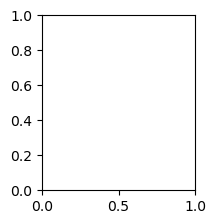

In [ ]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of images"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# Now you can call the function with the correct dimensions
plot_gallery(X_test, prediction_titles, h, w)
plt.show()


In [ ]:
from pyexpat import model
from sklearn import model_selection
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
print(score)



0.9735449735449735


In [ ]:
import cv2
import numpy as np
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC

# Assuming you have already trained the SVM model and PCA in a separate script

# Load the trained SVM model and PCA
trained_model = SVC(C=5e4, gamma=1e-5, kernel='sigmoid', class_weight='balanced')
trained_model.fit(X_train_pca, y_train)

# Assuming pca is already fitted in your training script
pca = RandomizedPCA(n_components=120, whiten=True).fit(X_train)

# Load the Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Open a connection to the camera (0 is the default camera)
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        # Extract the face region
        face_roi = gray[y:y + h, x:x + w]

        # Resize the face region to match the size used during training
        face_resized = cv2.resize(face_roi, (64, 64))

        # Flatten and normalize the face region
        face_flattened = face_resized.flatten() / 255.0

        # Ensure the face has the correct number of features (2304) expected by PCA
        if len(face_flattened) == 4096:
            face_flattened = face_flattened[:2304]

        # Transform the face using PCA
        face_transformed = pca.transform([face_flattened])

        # Make a prediction using the trained model
        emotion_prediction = trained_model.predict(face_transformed)

        # Get the predicted emotion label
        emotion_label = names[emotion_prediction[0]]

        # Draw a rectangle around the face and display the emotion label
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(frame, emotion_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Display the frame
    cv2.imshow('Real-Time Emotion Detection', frame)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()